In [1]:
#Imports 
from keras.models import *
from keras.layers import *
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from matplotlib import pyplot
from matplotlib.image import imread
from numpy import *
from numpy.random import *
import numpy as np
import sys

## Imports #########################################################################
from numpy.random import randn
from numpy.random import randint

sys.path.append('..')

# tf.debugging.set_log_device_placement(True)

In [2]:
#Import Data and Pre-Process

####################################################################################################
#Folders
folderURLs = np.array(["../Pokemon_Image_Dataset/yellow/", "../Pokemon_Image_Dataset/red-blue/", 
                      "../Pokemon_Image_Dataset/red-green/", "../Pokemon_Image_Dataset/silver/",
                      "../Pokemon_Image_Dataset/gold/", "../Pokemon_Image_Dataset/crystal/", "../Pokemon_Image_Dataset/firered-leafgreen/",
                      "../Pokemon_Image_Dataset/ruby-sapphire/", "../Pokemon_Image_Dataset/emerald/",
                      "../Pokemon_Image_Dataset/diamond-pearl/", "../Pokemon_Image_Dataset/platinum/",
                      "../Pokemon_Image_Dataset/black-white/", "../Pokemon_Image_Dataset/heartgold-soulsilver/"])

folderImgLastIndex = np.array([151, 151, 151, 251, 251, 251, 389, 387, 388, 512, 514, 750, 572])
folderCount = len(folderURLs)

####################################################################################################
#Import Data
#def whiteBackground(image):
#    for i in range(64):
#        for j in range(64):
#            if image[i,j,3] == 0.0:
#                image[i,j,0] = 0.0
#                image[i,j,1] = 0.0
#                image[i,j,2] = 0.0
#    return image

pokemonData_All = []
pokemonObjectLabels_All = []
pokemonTypeLabels_All = []

for folder in range(6, 13):
    labelsURL = folderURLs[folder] + "labels"
    file = open(labelsURL, 'r')
    Lines = file.readlines()
    #newImgNum = 1
    for img in range(1, folderImgLastIndex[folder] + 1):
        try:
            imgURL = folderURLs[folder] + str(img)
            image = imread(imgURL, format="png")
            
            #img = Image.open(imgURL)
            #image = whiteBackground(image)
            #img = img.resize((64,64))
            
            #saveImgURL = folderURLs[folder] + str(newImgNum)
            #newImgNum += 1
            #img = img.save(saveImgURL, format="png")
            
            pokemonObjectLabels_All.append(Lines[img + 1][0:2].strip())
            pokemonTypeLabels_All.append(Lines[img + 1][2:5].strip())
            pokemonData_All.append(image)
        except:
            error = "No Image Found"

pokemonObjectLabels_All = np.asarray(pokemonObjectLabels_All)
pokemonTypeLabels_All = np.asarray(pokemonTypeLabels_All)
pokemonData_All = np.asarray(pokemonData_All)
pokemonData_All = pokemonData_All[:,:,:,0:3]
n_samples, x_size, y_size, n_channels = pokemonData_All.shape

(3279, 64, 64, 3)


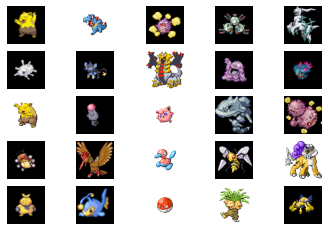

In [3]:
####################################################################################################
#Shuffle Then Plot Images From The Dataset
np.random.shuffle(pokemonData_All)
for i in range(25):
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(pokemonData_All[i])
    
print(pokemonData_All.shape)
pyplot.savefig("test.png")
pyplot.show()

In [4]:
#Functions/ Define Models

#################################################################################################### 
#Building Discriminator Model
def define_Discriminator(in_shape=(64,64,3), n_classes=19):
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    in_label = Input(shape=(1,))
    
    li = Embedding(n_classes, 50)(in_label)
    n_nodes = in_shape[0] * in_shape[1]
    
    li = Dense(n_nodes)(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    
    in_image = Input(shape=in_shape)
    merge = Concatenate()([in_image, li])
    
    fe = Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=in_shape)(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    fe = Conv2D(128, kernel_size=4, strides=2, padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Conv2D(128, kernel_size=4, strides=2, padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    fe = Flatten()(fe)
    #model.add(Dropout(0.2))
    out_layer = Dense(1, activation='sigmoid')(fe)
    model = Model([in_image, in_label], out_layer)
    #Compile model
    opt = Adam(learning_rate=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

#################################################################################################### 
#Building Generator Model
def define_Generator(latent_dim, n_classes=19):
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    in_label = Input(shape=(1,))
    
    li = Embedding(n_classes, 50)(in_label)
    n_nodes = 8 * 8
    
    li = Dense(n_nodes)(li)
    li = Reshape((8, 8, 1))(li)
    in_lat = Input(shape=(latent_dim,))
    
    n_nodes = 256 * 8 * 8
    gen = Dense(n_nodes, kernel_initializer=initializer)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((8, 8, 256))(gen)
    
    merge = Concatenate()([gen, li])
    
    gen = Conv2DTranspose(256, kernel_size=4, strides=2, padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    gen = Conv2DTranspose(256, kernel_size=4, strides=2, padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    gen = Conv2DTranspose(256, kernel_size=4, strides=2, padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    out_layer = Conv2D(3, kernel_size=5, activation='sigmoid', padding='same')(gen)
    model = Model([in_lat, in_label], out_layer)
    return model

#################################################################################################### 
#Building GAN Model From Discriminator And Generator Models
def define_gan(g_model, d_model):
    #Make Weights In The Discriminator Not Trainable
    d_model.trainable = False
    
    gen_noise, gen_label = g_model.input
    gen_output = g_model.output
    gan_output = d_model([gen_output, gen_label])
    model = Model([gen_noise, gen_label], gan_output)

    opt = Adam(learning_rate=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [5]:
#Auxiliary Functions

#################################################################################################### 
#Functions For Discriminator Model
def load_real_samples(dataset, labels):
    labels = labels.astype('float32')
    return [dataset, labels]

def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y
        
####################################################################################################        
#Functions For Generator Model
def generate_latent_points(latent_dim, n_samples, n_classes=19):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

#################################################################################################### 
#Train GAN Save Model And Plots
def save_plot(examples, epoch, n=5):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
    # save plot to file
    filename = 'Images/generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

#Evaluate The Discriminator, Plot Generated Images, Save Generator Model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=200):
    # prepare real samples
    [X_real, labels_real], y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate([X_real, labels_real], y_real, verbose=0)
    # prepare fake examples
    [x_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    #x_fake = (x_fake + 1) / 2.0
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate([x_fake, labels_fake], y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    print(x_fake.shape)
    # save the generator model tile file
    filename = 'Models/generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)
    
#Train The Generator And Discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=15000, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        950         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 4096)      208896      ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                              

2022-05-19 12:04:50.115957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 12:04:50.137205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 12:04:50.137315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 12:04:50.137544: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(9, 64, 64, 3)


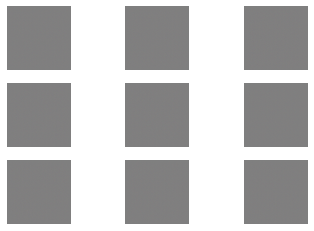

In [6]:
#Model Summaries

####################################################################################################
#Define Discriminator Model
d_model = define_Discriminator()

#Summarize Discriminator Model
d_model.summary()

####################################################################################################
#Define The Size Of The latent Space
latent_dim = 100

#Define Generator Model
g_model = define_Generator(latent_dim)

#Summarize Generator Model
g_model.summary()

#Generate Latent Samples
# n_latent_samples = 9
# [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, n_latent_samples)
# print(X_fake.shape)
# #X = (X + 1) / 2.0
# #Plot The Generated Samples
# for i in range(n_latent_samples):
#     #Define Subplot
#     pyplot.subplot(3, 3, 1 + i)
#     #Turn Off Axis Labels
#     pyplot.axis('off')
#     #Plot Single Image
#     pyplot.imshow(X_fake[i])
    
# #Show The Samples
# pyplot.show()

In [ ]:
#Training And Output

####################################################################################################
#Retrieve Our Training Data Set Which Has Been Normalized Between (0-1)
dataset = load_real_samples(pokemonData_All, pokemonObjectLabels_All)

# #Define GAN Model
gan_model = define_gan(g_model, d_model)

# #Train GAN Model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/25, d1=0.677, d2=0.792 g=0.646
>1, 2/25, d1=0.647, d2=0.758 g=0.668
>1, 3/25, d1=0.658, d2=0.723 g=0.702
>1, 4/25, d1=0.673, d2=0.695 g=0.724
>1, 5/25, d1=0.681, d2=0.670 g=0.749
>1, 6/25, d1=0.704, d2=0.657 g=0.758
>1, 7/25, d1=0.695, d2=0.649 g=0.770
>1, 8/25, d1=0.683, d2=0.636 g=0.790
>1, 9/25, d1=0.687, d2=0.619 g=0.807
>1, 10/25, d1=0.694, d2=0.610 g=0.822
>1, 11/25, d1=0.718, d2=0.606 g=0.824
>1, 12/25, d1=0.709, d2=0.610 g=0.822
>1, 13/25, d1=0.732, d2=0.619 g=0.807
>1, 14/25, d1=0.705, d2=0.634 g=0.790
>1, 15/25, d1=0.673, d2=0.648 g=0.777
>1, 16/25, d1=0.633, d2=0.653 g=0.773
>1, 17/25, d1=0.610, d2=0.646 g=0.776
>1, 18/25, d1=0.538, d2=0.641 g=0.776
>1, 19/25, d1=0.435, d2=0.665 g=0.749
>1, 20/25, d1=0.363, d2=0.735 g=0.685
>1, 21/25, d1=0.322, d2=0.824 g=0.631
>1, 22/25, d1=0.293, d2=0.883 g=0.617
>1, 23/25, d1=0.284, d2=0.934 g=0.618
>1, 24/25, d1=0.303, d2=0.964 g=0.623
>1, 25/25, d1=0.373, d2=0.935 g=0.659
>2, 1/25, d1=0.444, d2=0.827 g=0.729
>2, 2/25, d1=0.544, d2